# Conversión de categóricas a numéricas

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import root_mean_squared_error # ?????


In [143]:
import sys, os
sys.path.append(os.getcwd().replace('/notebooks',''))  # Replace with current directory name

In [144]:
from utils.data import Datasets
from utils.eda import column_explore

In [145]:
ds = Datasets()
cash, fees = ds.get_datasets()
cash = ds.desglose_created_at(cash)

In [146]:
cash.columns

Index(['cash_request_id', 'amount', 'status', 'created_at', 'updated_at',
       'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'id_usuario', 'created_year', 'created_month', 'created_year_month',
       'created_dayofweek', 'created_hour'],
      dtype='object')

In [147]:
fees.columns

Index(['id', 'cash_request_id', 'type', 'status', 'category', 'total_amount',
       'reason', 'created_at', 'updated_at', 'paid_at', 'from_date', 'to_date',
       'charge_moment'],
      dtype='object')

In [148]:
subset_cash=['cash_request_id','amount','status','transfer_type','recovery_status','user_id','deleted_account_id','id_usuario','created_year_month','created_at','created_dayofweek','created_hour']
cash_ss = cash[subset_cash]
cash_ss

,cash_request_id,amount,status,transfer_type,recovery_status,user_id,deleted_account_id,id_usuario,created_year_month,created_at,created_dayofweek,created_hour
0,5,100.0,rejected,regular,NaN,804.0,NaN,804,2019-12,2019-12-10 19:05:21.596873+00:00,2,19
1,70,100.0,rejected,regular,NaN,231.0,NaN,231,2019-12,2019-12-10 19:50:12.347780+00:00,2,19
2,7,100.0,rejected,regular,NaN,191.0,NaN,191,2019-12,2019-12-10 19:13:35.825460+00:00,2,19
3,10,99.0,rejected,regular,NaN,761.0,NaN,761,2019-12,2019-12-10 19:16:10.880172+00:00,2,19
4,1594,100.0,rejected,regular,NaN,7686.0,NaN,7686,2020-5,2020-05-06 09:59:38.877376+00:00,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
23965,20616,100.0,money_back,instant,NaN,13681.0,NaN,13681,2020-10,2020-10-12 13:54:11.686225+00:00,1,13
23966,25243,50.0,money_back,instant,completed,NaN,30367.0,30367,2020-10,2020-10-27 14:41:25.734910+00:00,2,14
23967,22357,100.0,money_back,instant,NaN,82122.0,NaN,82122,2020-10,2020-10-20 07:58:04.006937+00:00,2,7
23968,20256,100.0,money_back,instant,NaN,64517.0,NaN,64517,2020-10,2020-10-10 05:40:55.700422+00:00,6,5


In [149]:
subset_fees=['id','cash_request_id','type', 'status', 'category', 'total_amount','charge_moment']
fees_ss = fees[subset_fees]
fees_ss

,id,cash_request_id,type,status,category,total_amount,charge_moment
0,6537,14941,instant_payment,rejected,NaN,5.0,after
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,after
2,16296,23371,instant_payment,accepted,NaN,5.0,after
3,20775,26772,instant_payment,accepted,NaN,5.0,after
4,11242,19350,instant_payment,accepted,NaN,5.0,after
...,...,...,...,...,...,...,...
21056,12372,20262,instant_payment,rejected,NaN,5.0,after
21057,20768,26764,instant_payment,rejected,NaN,5.0,after
21058,18779,25331,instant_payment,rejected,NaN,5.0,after
21059,16542,23628,instant_payment,rejected,NaN,5.0,after


In [150]:
merged = pd.merge(cash_ss, fees_ss.add_prefix('fee_'), left_on='cash_request_id', right_on='fee_cash_request_id', how='outer') # 32098 rows

In [151]:
# metricas_usuario[metricas_usuario['deleted_account_id'].isna()] # 1309
merged[merged['user_id'].isna()]
merged['user_id'].fillna(0)
merged['existing_account'] = merged['user_id'].transform(lambda x: 1 if x > 0 else 0)
merged['existing_account'].value_counts()

existing_account
1    29522
0     2576
Name: count, dtype: int64

In [152]:
top100 = merged[merged['status']=='money_back'].groupby('id_usuario').agg(
    amount_fees=('fee_total_amount','sum'))
top100_usrs = top100.sort_values(by='amount_fees', ascending=False).iloc[:100].index
top100_usrs

Index([16391.0,  7731.0, 15593.0, 17144.0,  3045.0, 23823.0,   528.0, 13607.0,
       21934.0, 11648.0, 20447.0, 14583.0,  8649.0, 13404.0, 21706.0, 14375.0,
       20871.0, 34243.0, 23661.0, 14953.0, 19730.0,  4636.0, 10173.0,  2562.0,
       50026.0, 33993.0, 33181.0,  7210.0, 21035.0,   421.0, 28932.0, 14443.0,
       52530.0, 41679.0, 21453.0, 19333.0,  9854.0,  5267.0,  7445.0, 25464.0,
       89394.0, 14218.0, 37862.0, 10530.0,   526.0, 15716.0, 14892.0, 24288.0,
       18984.0, 11201.0, 19055.0, 19257.0,  4954.0, 12934.0, 16459.0, 18787.0,
       12888.0, 29205.0, 18464.0, 18006.0, 14419.0,   235.0, 27401.0, 14304.0,
       33889.0, 24590.0, 15536.0, 30956.0,  1017.0, 16864.0,  2548.0, 27117.0,
       27005.0, 26342.0,  2012.0, 16521.0,    47.0, 22623.0, 11557.0,  8341.0,
        8496.0, 40138.0,  6207.0,  5230.0,  6916.0, 36054.0, 53083.0, 35753.0,
        4916.0, 39068.0, 11939.0, 13045.0, 12724.0, 26653.0, 20421.0, 35374.0,
       17089.0, 24724.0, 17531.0, 19986.0],
      dt

In [153]:
top_users = merged[merged['id_usuario'].isin(top100_usrs)].reset_index()
top_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   index                1486 non-null   int64              
 1   cash_request_id      1486 non-null   float64            
 2   amount               1486 non-null   float64            
 3   status               1486 non-null   object             
 4   transfer_type        1486 non-null   object             
 5   recovery_status      533 non-null    object             
 6   user_id              1309 non-null   float64            
 7   deleted_account_id   177 non-null    float64            
 8   id_usuario           1486 non-null   float64            
 9   created_year_month   1486 non-null   object             
 10  created_at           1486 non-null   datetime64[ns, UTC]
 11  created_dayofweek    1486 non-null   float64            
 12  created_hour        

In [154]:
top_users['fee_charge_moment'].value_counts()

fee_charge_moment
after     1084
before     232
Name: count, dtype: int64

In [155]:
top_users['status'].value_counts()

status
money_back               1383
rejected                  100
canceled                    1
transaction_declined        1
direct_debit_rejected       1
Name: count, dtype: int64

In [156]:
top_users['fee_category'].value_counts()

fee_category
rejected_direct_debit     66
month_delay_on_payment    11
Name: count, dtype: int64

In [157]:
top_users.drop(columns=['recovery_status','deleted_account_id'], inplace=True)

In [158]:
top_users.drop(columns=['user_id'], inplace=True)

In [159]:
top_users[top_users['fee_category'].isna()].sample(20)
top_users['fee_category'].fillna('ninguna', inplace=True)

/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_20398/1062051603.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  top_users['fee_category'].fillna('ninguna', inplace=True)


In [160]:
top_users.dropna(inplace=True, ignore_index=True)

In [161]:
top_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   index                1316 non-null   int64              
 1   cash_request_id      1316 non-null   float64            
 2   amount               1316 non-null   float64            
 3   status               1316 non-null   object             
 4   transfer_type        1316 non-null   object             
 5   id_usuario           1316 non-null   float64            
 6   created_year_month   1316 non-null   object             
 7   created_at           1316 non-null   datetime64[ns, UTC]
 8   created_dayofweek    1316 non-null   float64            
 9   created_hour         1316 non-null   float64            
 10  fee_id               1316 non-null   float64            
 11  fee_cash_request_id  1316 non-null   float64            
 12  fee_type            

In [162]:
# Beneficio por cliente
# Nota: las columnas 'status','fee_type', 'fee_status' no aportan variabilidad (i.e. todas tienen el mismo valor). P.t. ya no las incluiremos
metricas_usuario = top_users.groupby(['created_year_month','created_dayofweek','created_hour','id_usuario','existing_account','status',
        'transfer_type','fee_category','fee_charge_moment']).agg(
    num_peticiones=('cash_request_id', 'count'),
    amount=('amount', 'sum'),
    num_fees=('fee_id','count'),
    amount_fees=('fee_total_amount','sum'))
print(metricas_usuario.shape)
metricas_usuario.sample(20)

(430, 4)


num_peticiones  \
created_year_month created_dayofweek created_hour id_usuario existing_account status     transfer_type fee_category          fee_charge_moment                   
2020-7             5.0               16.0         21706.0    0                money_back regular       rejected_direct_debit after                           1   
2020-8             7.0               20.0         8649.0     1                money_back instant       ninguna               before                          2   
2020-10            3.0               11.0         15716.0    1                money_back instant       ninguna               after                           1   
2020-6             4.0               6.0          4916.0     1                money_back regular       ninguna               after                           6   
2020-10            7.0               7.0          12888.0    1                money_back instant       ninguna               after                           1   
2020-6             4.0               7.0          21035.0    0                money_back regular       ninguna               after                           2   
2020-10            1.0               17.0         526.0      1                money_back instant       ninguna               before                          1   
                   3.0               13.0         18984.0    1                money_back instant       ninguna               after                           1   
2020-8             5.0               14.0         528.0      1                money_back instant       ninguna               after                          19   
                   6.0               21.0         2562.0     1                money_back regular       rejected_direct_debit after                           1   
                   5.0               15.0         15716.0    1                money_back instant       rejected_direct_debit after                           1   
2020-6             2.0               19.0         11201.0    1                money_back regular       ninguna               after                           7   
2020-10            5.0               12.0         36054.0    1                money_back instant       ninguna               after                           1   
2020-6             1.0               10.0         19257.0    0                money_back regular       ninguna               after                           2   
2020-8             5.0               7.0          33181.0    1                money_back instant       rejected_direct_debit after                           1   
2020-9             5.0               7.0          40138.0    1                money_back instant       ninguna               after                          10   
2020-10            3.0               15.0         24590.0    1                money_back instant       ninguna               after                           1   
                   6.0               7.0          19986.0    1                money_back instant       ninguna               before                          2   
2020-6             3.0               17.0         19730.0    0                money_back regular       rejected_direct_debit after                           1   
2020-8             2.0               10.0         11939.0    1                money_back instant       ninguna               after                           2   

                                                                                                                                                amount  \
created_year_month created_dayofweek created_hour id_usuario existing_account status     transfer_type fee_category          fee_charge_moment           
2020-7             5.0               16.0         21706.0    0                money_back regular       rejected_direct_debit after               100.0   
2020-8             7.0               20.0         8649.0     1                money_back instant       ninguna       

## Regresión

In [163]:
df = metricas_usuario.reset_index()
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,status,transfer_type,fee_category,fee_charge_moment,num_peticiones,amount,num_fees,amount_fees
0,2020-10,1.0,6.0,4636.0,1,money_back,instant,ninguna,after,1,100.0,1,5.0
1,2020-10,1.0,9.0,21453.0,0,money_back,instant,ninguna,after,1,100.0,1,5.0
2,2020-10,1.0,14.0,526.0,1,transaction_declined,instant,ninguna,after,1,90.0,1,5.0
3,2020-10,1.0,17.0,526.0,1,money_back,instant,ninguna,after,1,90.0,1,5.0
4,2020-10,1.0,17.0,526.0,1,money_back,instant,ninguna,before,1,90.0,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,money_back,instant,ninguna,before,2,200.0,2,10.0
426,2020-9,7.0,7.0,52530.0,1,money_back,instant,ninguna,after,2,200.0,2,10.0
427,2020-9,7.0,17.0,24288.0,1,money_back,instant,ninguna,after,2,200.0,2,10.0
428,2020-9,7.0,17.0,24288.0,1,money_back,instant,ninguna,before,1,100.0,1,5.0


In [164]:
df.fee_charge_moment.value_counts().sort_index()

fee_charge_moment
after     321
before    109
Name: count, dtype: int64

In [165]:
df.created_year_month.value_counts().sort_index()

created_year_month
2020-10     86
2020-5      11
2020-6      71
2020-7      56
2020-8     123
2020-9      83
Name: count, dtype: int64

In [166]:
df.fee_charge_moment.value_counts().sort_index()

fee_charge_moment
after     321
before    109
Name: count, dtype: int64

In [167]:
df = ds.get_dummies_and_drop_cols(df, '', 'status')
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,transfer_type,fee_category,fee_charge_moment,num_peticiones,amount,num_fees,amount_fees,status_money_back,status_transaction_declined
0,2020-10,1.0,6.0,4636.0,1,instant,ninguna,after,1,100.0,1,5.0,1,0
1,2020-10,1.0,9.0,21453.0,0,instant,ninguna,after,1,100.0,1,5.0,1,0
2,2020-10,1.0,14.0,526.0,1,instant,ninguna,after,1,90.0,1,5.0,0,1
3,2020-10,1.0,17.0,526.0,1,instant,ninguna,after,1,90.0,1,5.0,1,0
4,2020-10,1.0,17.0,526.0,1,instant,ninguna,before,1,90.0,1,5.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,instant,ninguna,before,2,200.0,2,10.0,1,0
426,2020-9,7.0,7.0,52530.0,1,instant,ninguna,after,2,200.0,2,10.0,1,0
427,2020-9,7.0,17.0,24288.0,1,instant,ninguna,after,2,200.0,2,10.0,1,0
428,2020-9,7.0,17.0,24288.0,1,instant,ninguna,before,1,100.0,1,5.0,1,0


In [168]:
df = ds.get_dummies_and_drop_cols(df, '', 'transfer_type')
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,fee_category,fee_charge_moment,num_peticiones,amount,num_fees,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular
0,2020-10,1.0,6.0,4636.0,1,ninguna,after,1,100.0,1,5.0,1,0,0
1,2020-10,1.0,9.0,21453.0,0,ninguna,after,1,100.0,1,5.0,1,0,0
2,2020-10,1.0,14.0,526.0,1,ninguna,after,1,90.0,1,5.0,0,1,0
3,2020-10,1.0,17.0,526.0,1,ninguna,after,1,90.0,1,5.0,1,0,0
4,2020-10,1.0,17.0,526.0,1,ninguna,before,1,90.0,1,5.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,ninguna,before,2,200.0,2,10.0,1,0,0
426,2020-9,7.0,7.0,52530.0,1,ninguna,after,2,200.0,2,10.0,1,0,0
427,2020-9,7.0,17.0,24288.0,1,ninguna,after,2,200.0,2,10.0,1,0,0
428,2020-9,7.0,17.0,24288.0,1,ninguna,before,1,100.0,1,5.0,1,0,0


In [169]:
df = ds.get_dummies_and_drop_cols(df, '', 'fee_category')
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,fee_charge_moment,num_peticiones,amount,num_fees,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular,fee_category_ninguna,fee_category_rejected_direct_debit
0,2020-10,1.0,6.0,4636.0,1,after,1,100.0,1,5.0,1,0,0,1,0
1,2020-10,1.0,9.0,21453.0,0,after,1,100.0,1,5.0,1,0,0,1,0
2,2020-10,1.0,14.0,526.0,1,after,1,90.0,1,5.0,0,1,0,1,0
3,2020-10,1.0,17.0,526.0,1,after,1,90.0,1,5.0,1,0,0,1,0
4,2020-10,1.0,17.0,526.0,1,before,1,90.0,1,5.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,before,2,200.0,2,10.0,1,0,0,1,0
426,2020-9,7.0,7.0,52530.0,1,after,2,200.0,2,10.0,1,0,0,1,0
427,2020-9,7.0,17.0,24288.0,1,after,2,200.0,2,10.0,1,0,0,1,0
428,2020-9,7.0,17.0,24288.0,1,before,1,100.0,1,5.0,1,0,0,1,0


In [170]:
df = ds.get_dummies_and_drop_cols(df, '', 'fee_charge_moment')
df

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,num_peticiones,amount,num_fees,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular,fee_category_ninguna,fee_category_rejected_direct_debit,fee_charge_moment_before
0,2020-10,1.0,6.0,4636.0,1,1,100.0,1,5.0,1,0,0,1,0,0
1,2020-10,1.0,9.0,21453.0,0,1,100.0,1,5.0,1,0,0,1,0,0
2,2020-10,1.0,14.0,526.0,1,1,90.0,1,5.0,0,1,0,1,0,0
3,2020-10,1.0,17.0,526.0,1,1,90.0,1,5.0,1,0,0,1,0,0
4,2020-10,1.0,17.0,526.0,1,1,90.0,1,5.0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,2,200.0,2,10.0,1,0,0,1,0,1
426,2020-9,7.0,7.0,52530.0,1,2,200.0,2,10.0,1,0,0,1,0,0
427,2020-9,7.0,17.0,24288.0,1,2,200.0,2,10.0,1,0,0,1,0,0
428,2020-9,7.0,17.0,24288.0,1,1,100.0,1,5.0,1,0,0,1,0,1


In [171]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['created_year_month_dummy'] = labelencoder.fit_transform(df['created_year_month']) 
df      

,created_year_month,created_dayofweek,created_hour,id_usuario,existing_account,num_peticiones,amount,num_fees,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular,fee_category_ninguna,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
0,2020-10,1.0,6.0,4636.0,1,1,100.0,1,5.0,1,0,0,1,0,0,0
1,2020-10,1.0,9.0,21453.0,0,1,100.0,1,5.0,1,0,0,1,0,0,0
2,2020-10,1.0,14.0,526.0,1,1,90.0,1,5.0,0,1,0,1,0,0,0
3,2020-10,1.0,17.0,526.0,1,1,90.0,1,5.0,1,0,0,1,0,0,0
4,2020-10,1.0,17.0,526.0,1,1,90.0,1,5.0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2020-9,6.0,15.0,21453.0,0,2,200.0,2,10.0,1,0,0,1,0,1,5
426,2020-9,7.0,7.0,52530.0,1,2,200.0,2,10.0,1,0,0,1,0,0,5
427,2020-9,7.0,17.0,24288.0,1,2,200.0,2,10.0,1,0,0,1,0,0,5
428,2020-9,7.0,17.0,24288.0,1,1,100.0,1,5.0,1,0,0,1,0,1,5


In [172]:
# df.drop(columns=['num_peticiones','num_fees'], inplace=True)
df.drop(columns=['id_usuario','num_peticiones','num_fees'], inplace=True)

In [173]:
df_previous = pd.DataFrame(df[df['created_year_month']!='2020-10'])
df_previous.drop(columns=['created_year_month'], inplace=True)
df_previous

,created_dayofweek,created_hour,existing_account,amount,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular,fee_category_ninguna,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
86,3.0,10.0,1,1000.0,50.0,1,0,1,1,0,0,1
87,3.0,10.0,1,200.0,10.0,1,0,1,1,0,1,1
88,4.0,18.0,1,100.0,5.0,1,0,1,1,0,0,1
89,5.0,8.0,1,50.0,5.0,1,0,1,0,1,0,1
90,5.0,16.0,1,50.0,25.0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
425,6.0,15.0,0,200.0,10.0,1,0,0,1,0,1,5
426,7.0,7.0,1,200.0,10.0,1,0,0,1,0,0,5
427,7.0,17.0,1,200.0,10.0,1,0,0,1,0,0,5
428,7.0,17.0,1,100.0,5.0,1,0,0,1,0,1,5


In [174]:
df_last = pd.DataFrame(df[df['created_year_month']=='2020-10'])
df_last.drop(columns=['created_year_month'], inplace=True)
df_last

,created_dayofweek,created_hour,existing_account,amount,amount_fees,status_money_back,status_transaction_declined,transfer_type_regular,fee_category_ninguna,fee_category_rejected_direct_debit,fee_charge_moment_before,created_year_month_dummy
0,1.0,6.0,1,100.0,5.0,1,0,0,1,0,0,0
1,1.0,9.0,0,100.0,5.0,1,0,0,1,0,0,0
2,1.0,14.0,1,90.0,5.0,0,1,0,1,0,0,0
3,1.0,17.0,1,90.0,5.0,1,0,0,1,0,0,0
4,1.0,17.0,1,90.0,5.0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
81,6.0,19.0,1,250.0,25.0,1,0,0,1,0,1,0
82,6.0,22.0,1,1.0,5.0,1,0,0,1,0,0,0
83,7.0,6.0,1,100.0,5.0,1,0,0,1,0,0,0
84,7.0,6.0,1,100.0,5.0,1,0,0,1,0,1,0


<Axes: >

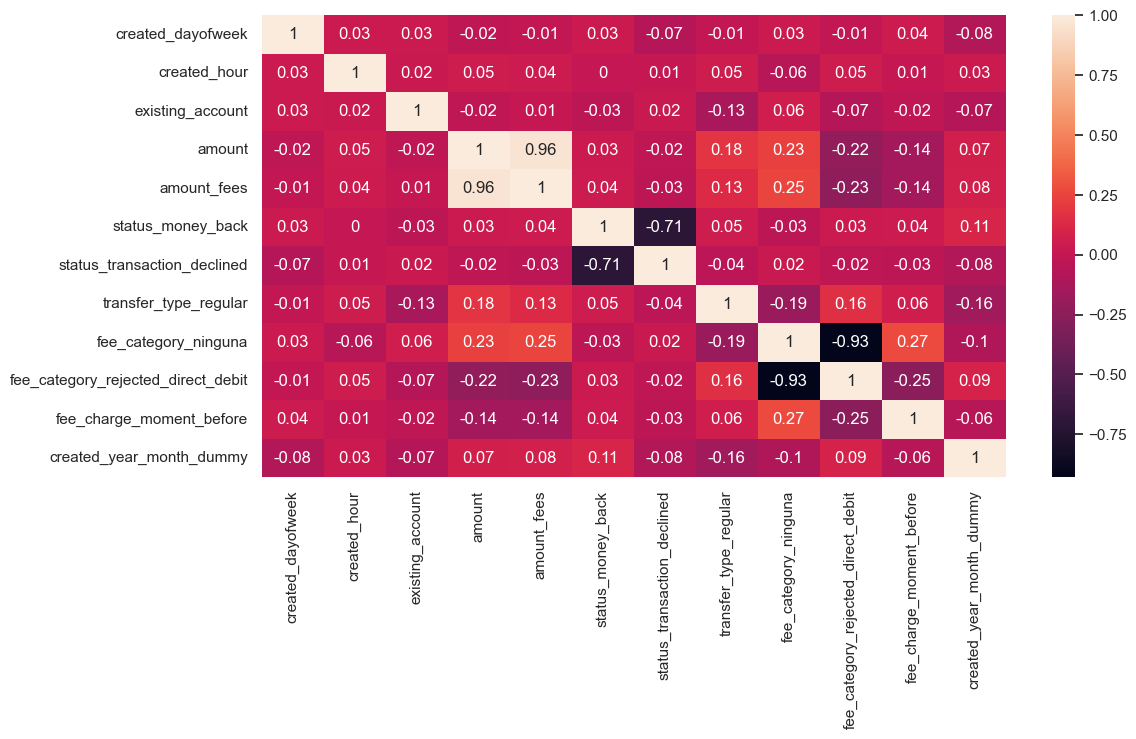

In [175]:
numericals = df.select_dtypes(np.number)
corr = numericals.corr()
import seaborn as sns
sns.set_context("poster") # Set the Seaborn context to "poster" for larger text and figures
sns.set(rc={"figure.figsize": (12., 6.)}) # Set the default figure size for Seaborn plots
sns.set_style("whitegrid") # Set the Seaborn style to "whitegrid" for a white background with gridlines

sns.heatmap(corr.round(2), annot=True)

In [176]:
X=df_previous.drop(columns='amount_fees')
y=df_previous['amount_fees']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=None, random_state=42)

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

# Sobrescribir conjuntos de prueba X_test y y_test con los valores de nuestro 3r mes
X_test = df_last.drop(columns='amount_fees')
y_test = df_last['amount_fees']

y_test_pred = model.predict(X_test)

# Evaluar el Modelo
print('-- Train -----')
mse = mean_squared_error(y_train, y_train_pred)
print(f"Error cuadrático medio (MSE) del modelo: {mse:.4f}")
r2 = r2_score(y_train, y_train_pred)
print(f"Valor R² del modelo: {r2:.4f}")
print()

print('-- Test -----')
mse = mean_squared_error(y_test, y_test_pred)
print(f"Error cuadrático medio (MSE) del modelo: {mse:.4f}")
r2 = r2_score(y_test, y_test_pred)
print(f"Valor R² del modelo: {r2:.4f}")
print()


-- Train -----
Error cuadrático medio (MSE) del modelo: 22.9950
Valor R² del modelo: 0.9419

-- Test -----
Error cuadrático medio (MSE) del modelo: 21.2960
Valor R² del modelo: 0.8121



### Gráfico de predicciones vs valores reales

<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_20398/243664275.py:20: SyntaxWarning: invalid escape sequence '\h'
  axs[0].set_ylabel('$\hat y$')
/var/folders/3h/d4zpwm_x4qg78bc5337r4q240000gq/T/ipykernel_20398/243664275.py:26: SyntaxWarning: invalid escape sequence '\h'
  axs[1].set_ylabel('$\hat y$')


Text(0.5, 0.98, 'Predicciones vs Valores Reales')

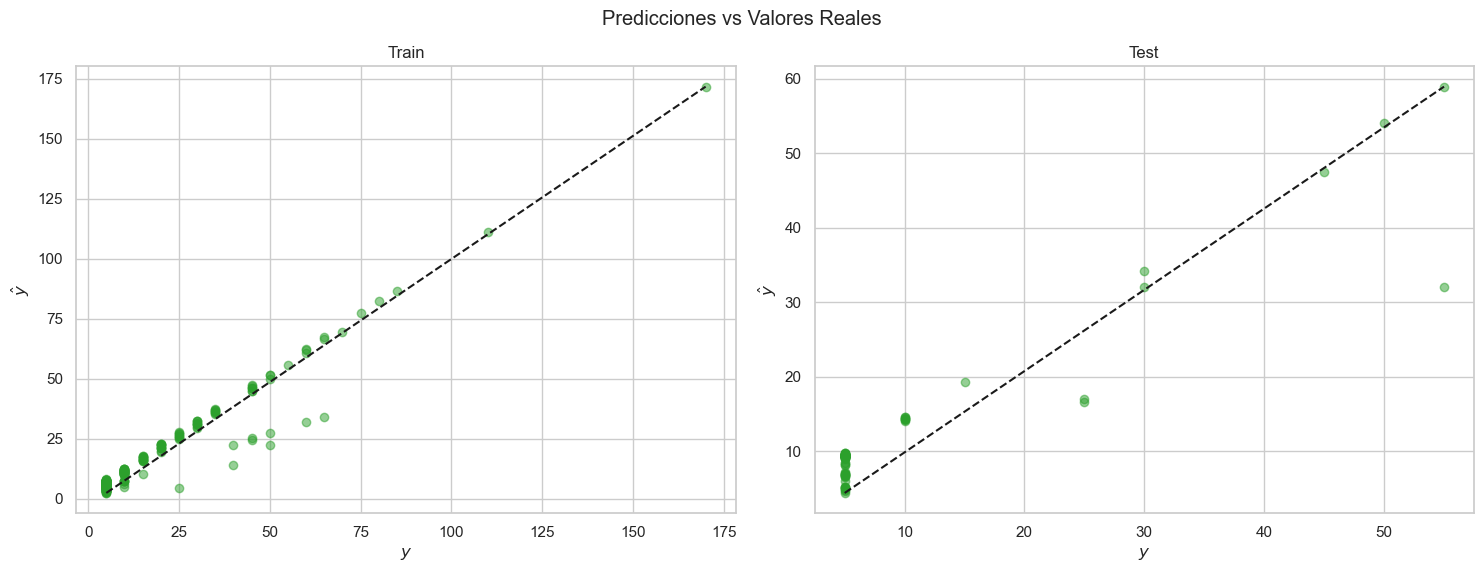

In [177]:
# plt.figure(figsize=(10, 6))
# plt.scatter(y_train, y_train_pred, c='tab:green', alpha=0.5)
# plt.plot([y_train.min(), y_train.max()], [y_train_pred.min(), y_train_pred.max()], '--k')
# plt.axis('tight')
# plt.xlabel('$y$')
# plt.ylabel('$\hat y$')
# plt.title('Predicciones vs Valores Reales (train)')

import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)
# warnings.resetwarnings()

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
#fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].scatter(y_train, y_train_pred, c='tab:green', alpha=0.5)
axs[0].plot([y_train.min(), y_train.max()], [y_train_pred.min(), y_train_pred.max()], '--k')
axs[0].set_title('Train')
axs[0].set_xlabel('$y$')
axs[0].set_ylabel('$\hat y$')

axs[1].scatter(y_test, y_test_pred, c='tab:green', alpha=0.5)
axs[1].plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], '--k')
axs[1].set_title('Test')
axs[1].set_xlabel('$y$')
axs[1].set_ylabel('$\hat y$')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect=[left, bottom, right, top]
fig.suptitle('Predicciones vs Valores Reales')

### Análisis de residuos

Text(0.5, 0.98, 'Gráfico de Residuos')

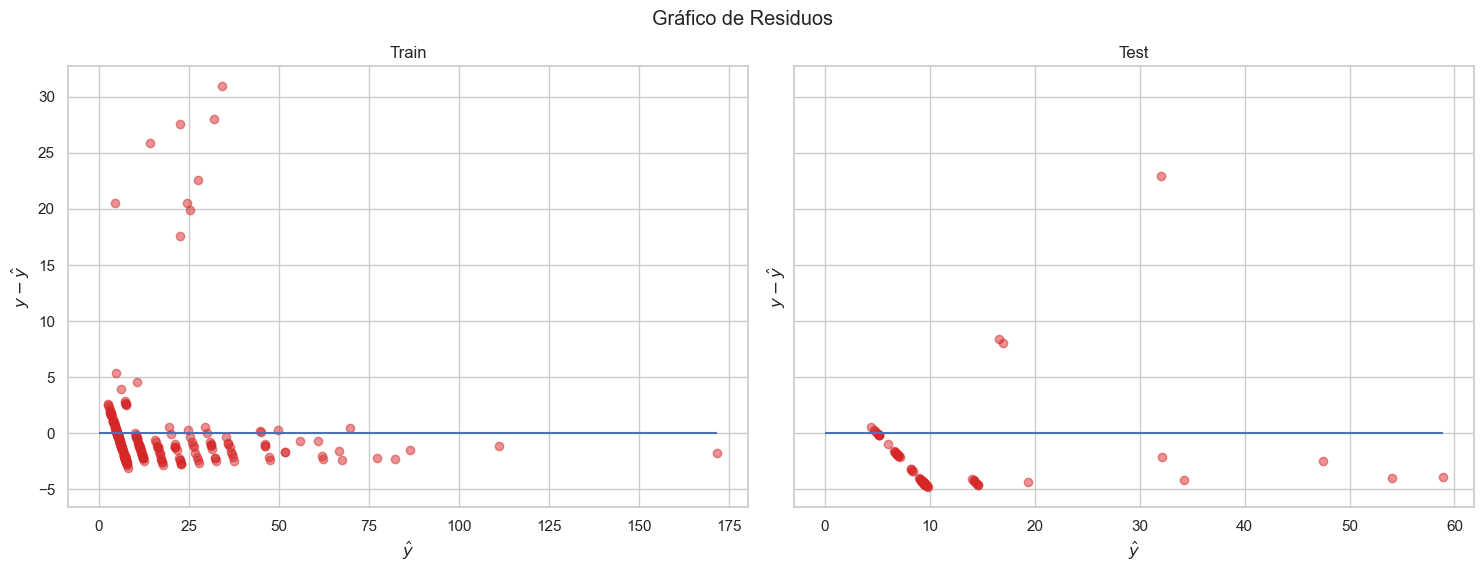

In [178]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred, alpha=0.7)
# plt.hlines(y=0, xmin=0, xmax=y_train_pred.max())
# plt.title('Gráfico de residuos')
# plt.xlabel('$\hat y$')
# plt.ylabel('$y - \hat y$')

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].scatter(x=y_train_pred, y=y_train - y_train_pred, c='tab:red', alpha=0.5)
axs[0].hlines(y=0, xmin=0, xmax=y_train_pred.max())
axs[0].set_title('Train')
axs[0].set_xlabel('$\hat y$')
axs[0].set_ylabel('$y - \hat y$')

axs[1].scatter(x=y_test_pred, y=y_test - y_test_pred, c='tab:red', alpha=0.5)
axs[1].hlines(y=0, xmin=0, xmax=y_test_pred.max())
axs[1].set_title('Test')
axs[1].set_xlabel('$\hat y$')
axs[1].set_ylabel('$y - \hat y$')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect=[left, bottom, right, top]
fig.suptitle('Gráfico de Residuos')

### Coeficientes


Intercepto del modelo: 1.7838644473080585

Coeficientes del modelo de LinearRegression:
 [-3.27362695e-02  3.55755345e-02  1.24703836e+00  4.96954764e-02
 -1.55431223e-15 -8.46545056e-16 -1.96675687e+00  1.15554597e+00
 -7.69894147e-02 -1.28112160e-01 -4.65258150e-01]

created_dayofweek                    -3.273627e-02
created_hour                          3.557553e-02
existing_account                      1.247038e+00
amount                                4.969548e-02
status_money_back                    -1.554312e-15
status_transaction_declined          -8.465451e-16
transfer_type_regular                -1.966757e+00
fee_category_ninguna                  1.155546e+00
fee_category_rejected_direct_debit   -7.698941e-02
fee_charge_moment_before             -1.281122e-01
created_year_month_dummy             -4.652582e-01
dtype: float64


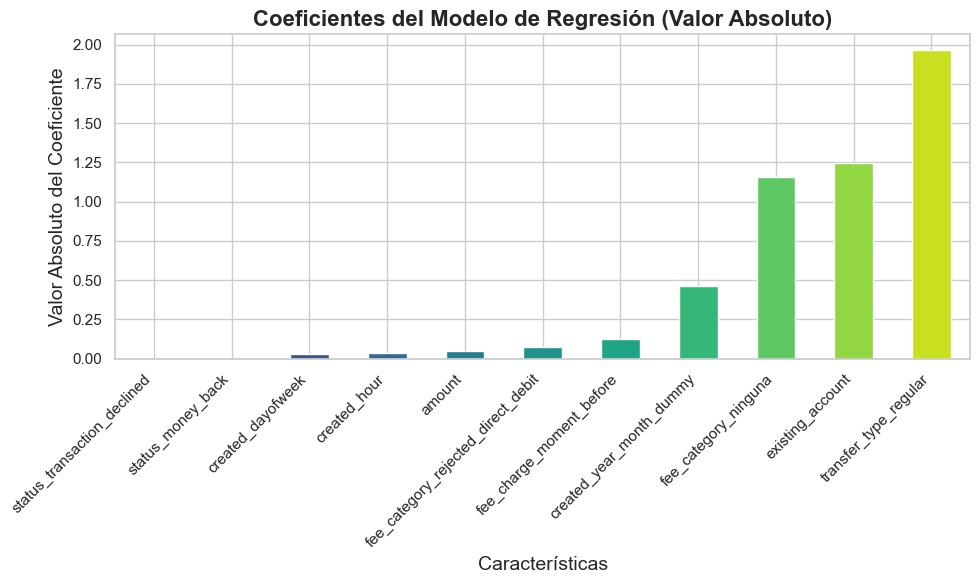

In [184]:
print('\nIntercepto del modelo:', model.intercept_)
print('\nCoeficientes del modelo de LinearRegression:\n', model.coef_)
print()

features = X.columns

print(pd.Series(model.coef_, index=features))

# Crear la gráfica de barras ordenada por valores absolutos de los coeficientes
plt.figure(figsize=(10, 6))

# Obtener los coeficientes de regresión
coefs_lr = pd.Series(np.abs(model.coef_), index=features).sort_values() # Valores absolutos para ordenarlos

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_lr.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_lr)))

# Título y etiquetas de ejes
plt.title('Coeficientes del Modelo de Regresión (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)

# Rotación y alineación de las etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar el espaciado para evitar solapamiento de elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### Regularización de Ridge


Intercepto del modelo: 1.8046781871021604

Coeficientes del modelo Ridge:
 [-0.03224832  0.03480496  1.21273059  0.04970577  0.          0.
 -1.89442066  1.01920449 -0.19984063 -0.11772905 -0.43503054]

Error Cuadrático Medio (MSE) en entrenamiento: 22.99617622655354
Error Cuadrático Medio (MSE) en prueba: 20.461727273330972

Puntaje R^2 en entrenamiento: 0.9419131601090872
Puntaje R^2 en prueba: 0.8194578604628162


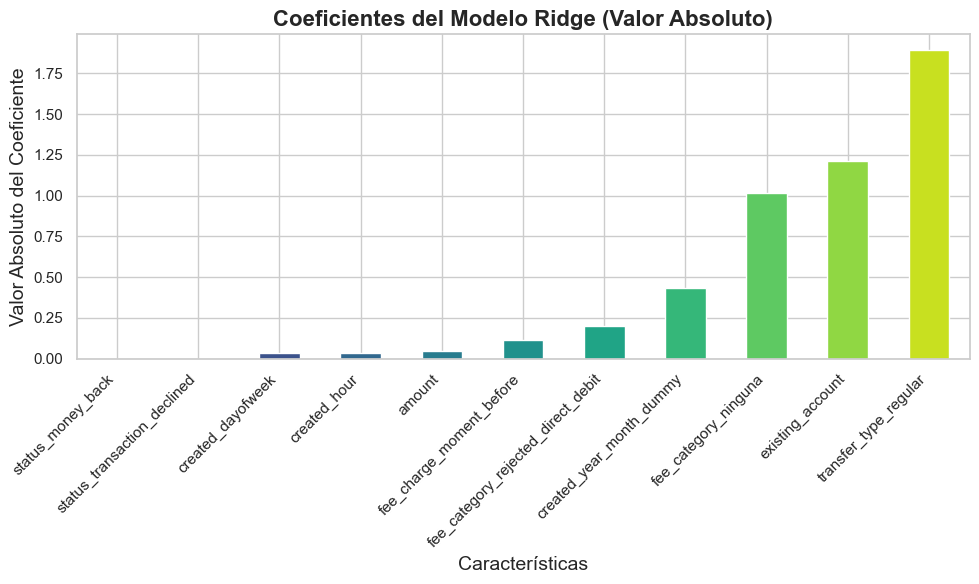

In [185]:
## Regresión Ridge
from sklearn import linear_model # Para la regresión Ridge
ridge = linear_model.Ridge(alpha=1) # Inicializamos el regresor Ridge con una penalización de 1
ridge.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento

# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_ridge = pd.Series(np.abs(ridge.coef_), index=features).sort_values(ascending=False)

# Realizamos la predicción en el conjunto de prueba y entrenamiento
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_ridge_train = mean_squared_error(y_train, y_train_pred_ridge) # MSE en entrenamiento
mse_ridge_test = mean_squared_error(y_test, y_test_pred_ridge) # MSE en prueba
r2score_ridge_train = ridge.score(X_train, y_train) # R^2 en entrenamiento
r2score_ridge_test = ridge.score(X_test, y_test) # R^2 en prueba

# Mostramos los resultados:
print('\nIntercepto del modelo:', ridge.intercept_)
print('\nCoeficientes del modelo Ridge:\n', ridge.coef_)
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_ridge_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_ridge_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_ridge_train)
print('Puntaje R^2 en prueba:', r2score_ridge_test)

# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_ridge.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_ridge)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)

# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')

# Ajuste del espaciado para evitar solapamientos
plt.tight_layout()

# Mostramos la gráfica con un diseño ajustado
plt.show()